# Extracting plane images from omni-directional image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import math

In [2]:
# parameters
class Parameter:
    def __init__(self):
        self.dir = r'.'
        self.imgfile = r'P89.jpg'

In [3]:
# functions
# resize np.array-type image: im: [0..255] or [0..1], sz = (height, width)
def imresize(im, sz):
    if np.amax(im) <= 1.0:
        im = im * 255
        scl = 255.0
    else:
        scl = 1
    pil_im = Image.fromarray(np.uint8(im))
    return np.array(pil_im.resize((sz[1], sz[0])))/scl

# rounding
def rnd(x):
    if type(x) is np.ndarray:
        return (x+0.5).astype(int)
    else:
        return round(x)

# polar cordinate: 
# cord.shepe=(3, c1, r1), cord[:,0,0]=[px, py, pz]
# or cord.shape = (3,), cord=[px, py, pz]
def polar(cord):
    if cord.ndim == 1:
        P = np.linalg.norm(cord)
    else:
        P = np.linalg.norm(cord, axis=0)
    phi = np.arcsin(cord[2] / P)
    theta_positive = np.arccos(cord[0] / np.sqrt(cord[0]**2 + cord[1]**2))
    theta_negative = - np.arccos(cord[0] / np.sqrt(cord[0]**2 + cord[1]**2))
    theta = (cord[1] > 0) * theta_negative + (cord[1] <= 0) * theta_positive
    return [theta, phi]

# r = [lower, upper]
def limit_values(x, r, xcopy=1):
    if xcopy == 1:
        ret = x.copy()
    else:
        ret = x
    ret[ret<r[0]] = r[0]
    ret[ret>r[1]] = r[1]
    return ret

In [4]:
# calculating polar cordinates of image plane in omni-directional image using camera parameters
class CameraPrm:
    # camera_angle, view_angle: [horizontal, vertical]
    # L: distance from camera to image plane
    def __init__(self, camera_angle, image_plane_size=None, view_angle=None, L=None):
        # camera direction (in radians) [horizontal, vertical]
        self.camera_angle = camera_angle
        
        # view_angle: angle of view in radians [horizontal, vertical]
        # image_plane_size: [image width, image height]
        if view_angle is None:
            self.image_plane_size = image_plane_size
            self.L = L
            self.view_angle = 2.0 * np.arctan(np.array(image_plane_size) / (2.0 * L))
        elif image_plane_size is  None:
            self.view_angle = view_angle
            self.L = L
            self.image_plane_size = 2.0 * L * np.tan(np.array(view_angle) / 2.0)
        else:
            self.image_plane_size = image_plane_size
            self.view_angle = view_angle
            L = (np.array(image_plane_size) / 2.0) / np.tan(np.array(view_angle) / 2.0)
            if rnd(L[0]) != rnd(L[1]):
                print('Warning: image_plane_size and view_angle are not matched.')
                va = 2.0 * np.arctan(np.array(image_plane_size) / (2.0 * L[0]))
                ips = 2.0 * L[0] * np.tan(np.array(view_angle) / 2.0)
                print('image_plane_size should be (' + str(ips[0]) + ', ' + str(ips[1]) +
                      '), or view_angle should be (' +  str(math.degrees(va[0])) + ', ' + str(math.degrees(va[1])) + ').' )
                return
            else:
                self.L = L[0]
        
        # unit vector of cameara direction
        self.nc = np.array([
                np.cos(camera_angle[1]) * np.cos(camera_angle[0]), 
                -np.cos(camera_angle[1]) * np.sin(camera_angle[0]), 
                np.sin(camera_angle[1])
            ])
        
        # center of image plane
        self.c0 = self.L * self.nc

        # unit vector (xn, yn) in image plane
        self.xn = np.array([
                -np.sin(camera_angle[0]), 
                -np.cos(camera_angle[0]),
                0
            ])
        self.yn = np.array([
                -np.sin(camera_angle[1]) * np.cos(camera_angle[0]), 
                np.sin(camera_angle[1]) * np.sin(camera_angle[0]),
                np.cos(camera_angle[1])
            ])
        
        # meshgrid in image plane
        [c1, r1] = np.meshgrid(np.arange(0, rnd(self.image_plane_size[0])), np.arange(0, rnd(self.image_plane_size[1])))
       
        # 2d-cordinates in image [xp, yp]
        img_cord = [c1 - self.image_plane_size[0] / 2.0, -r1 + self.image_plane_size[1] / 2.0]
        
        # 3d-cordinatess in image plane [px, py, pz]
        self.p = self.get_3Dcordinate(img_cord)
        
        # polar cordinates in image plane [theta, phi]
        self.polar_omni_cord = polar(self.p)
        
    def get_3Dcordinate(self, c):
        [xp, yp] = c
        if type(xp) is np.ndarray: # xp, yp: array
            return xp * self.xn.reshape((3,1,1)) + yp * self.yn.reshape((3,1,1)) + np.ones(xp.shape) * self.c0.reshape((3,1,1))
        else: # xp, yp: scalars
            return xp * self.xn + yp * self.yn + self.c0

In [5]:
# omni-drectional image
class OmniImage:
    def __init__(self, omni_image):
        if type(omni_image) is str:
            self.omni_image = plt.imread(omni_image)
        else:
            self.omni_image = omni_image
    
    def extract(self, camera_prm):
        # 2d-cordinates in omni-directional image [c2, r2]
        c2 = (camera_prm.polar_omni_cord[0] / (2.0 * np.pi) + 1.0 / 2.0) * self.omni_image.shape[1] - 0.5
        r2 = (-camera_prm.polar_omni_cord[1] / np.pi + 1.0/2.0) * self.omni_image.shape[0] - 0.5
        #[c2_int, r2_int] = [rnd(c2), rnd(r2)]
        c2_int = limit_values(rnd(c2), (0, self.omni_image.shape[1]-1), 0)
        r2_int = limit_values(rnd(r2), (0, self.omni_image.shape[0]-1), 0)
        #self.omni_cord = [c2, r2]
        return self.omni_image[r2_int, c2_int]

In [6]:
# embedding extracted image in omni-directional image
class Embedding:
    # omni_size: [omni_image width, omni_image height]
    def __init__(self, camera_prm, omni_size):
        print('Camera angle: (' + str(math.degrees(camera_prm.camera_angle[0])) + ', ' + str(math.degrees(camera_prm.camera_angle[1])) + ')')
        [c_omni, r_omni] = np.meshgrid(np.arange(omni_size[0]), np.arange(omni_size[1]))
        theta = (2.0 * c_omni / float(omni_size[0]-1) - 1.0) * np.pi
        phi = (0.5 - r_omni / float(omni_size[1]-1)) * np.pi
        pn = np.array([
                np.cos(phi) * np.cos(theta), 
                -np.cos(phi) * np.sin(theta), 
                np.sin(phi)
            ])
        pn = pn.transpose(1,2,0)
        
        # camera parameters
        L = camera_prm.L
        nc = camera_prm.nc
        xn = camera_prm.xn
        yn = camera_prm.yn
        theta_c = camera_prm.camera_angle[0]
        phi_c = camera_prm.camera_angle[1]
        theta_a = camera_prm.view_angle[0]
        phi_a = camera_prm.view_angle[1]
        w1 = camera_prm.image_plane_size[0]
        h1 = camera_prm.image_plane_size[1]
        
        # True: inside image (candidates), False: outside image
        cos_alpha = np.dot(pn, nc)
        mask = cos_alpha >= 2 * L / np.sqrt(w1**2 + h1**2 + 4*L**2) # circle
        
        r = np.zeros((omni_size[1], omni_size[0]))
        xp = np.zeros((omni_size[1], omni_size[0]))
        yp = np.zeros((omni_size[1], omni_size[0]))
        r[mask == True] = L / np.dot(pn[mask == True], nc)
        xp[mask == True] = r[mask == True] * np.dot(pn[mask == True], xn)
        yp[mask == True] = r[mask == True] * np.dot(pn[mask == True], yn)
        
        # True: inside image, False: outside image
        mask = (mask == True) & (xp > -w1/2.0) & (xp < w1/2.0) & (yp > -h1/2.0) & (yp < h1/2.0)
        r[mask == False] = 0
        xp[mask == False] = 0
        yp[mask == False] = 0
        
        self.camera_prm = camera_prm
        self.mask = mask
        self.r = r
        self.xp = xp
        self.yp = yp
        
    # embed extracted image in omni image
    def embed(self, imp):
        # 2D cordinates in extracted image
        [r1, c1] = np.array([imp.shape[0]/2.0 - self.yp - 0.5, imp.shape[1]/2.0 + self.xp - 0.5]) * self.mask
        #[r1_int, c1_int] = [rnd(r1), rnd(c1)]
        r1_int = limit_values(rnd(r1), (0, imp.shape[0]-1), 0)
        c1_int = limit_values(rnd(c1), (0, imp.shape[1]-1), 0)
        #[self.r1, self.c1] = [r1, c1]
        if imp.ndim == 3:
            ret = imp[r1_int, c1_int] * self.mask.reshape(self.mask.shape[0], self.mask.shape[1], -1)
        else:
            ret = imp[r1_int, c1_int] * self.mask
        
        return ret

In [7]:
# parameters
prm = Parameter()

# opne image
imc = OmniImage(prm.dir + '/' + prm.imgfile)
#imc = OmniImage(plt.imread(prm.dir + '/' + prm.imgfile))
#imc = OmniImage(plt.imread(prm.dir + '/' + prm.imgfile)[:,:,0])

(-0.5, 5375.5, 2687.5, -0.5)

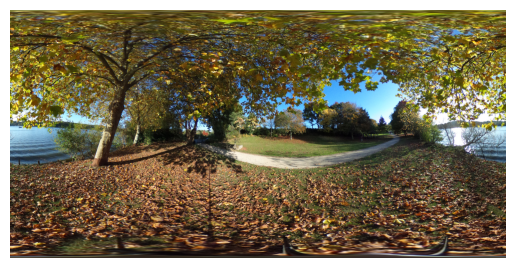

In [8]:
plt.imshow(imc.omni_image)
plt.axis('off')
#plt.gray()

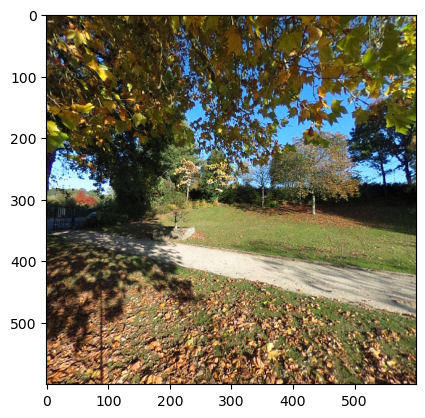

In [9]:
# camera parameters
[theta_c, phi_c] = [math.radians(0), math.radians(0)]
[theta_a, phi_a] = (math.radians(90), math.radians(90))
#cp = CameraPrm(camera_angle=(theta_c, phi_c), image_plane_size=(1000, 1000), L=1000)
cp = CameraPrm(camera_angle=(theta_c, phi_c), view_angle=(theta_a, phi_a), L=300)
#cp = CameraPrm(camera_angle=(theta_c, phi_c), image_plane_size=(500, 500), view_angle=(theta_a, phi_a))

# image extraction
imp = imc.extract(cp)
plt.imshow(imp)

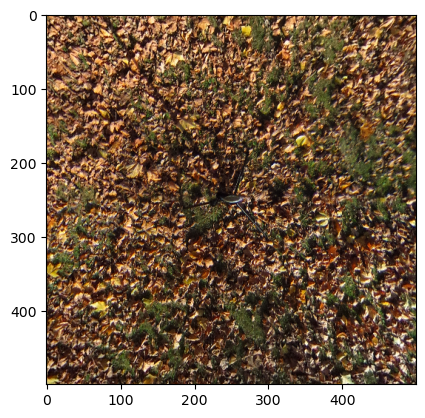

In [10]:
cp = CameraPrm(
            camera_angle=[math.radians(0), math.radians(-90)], 
            image_plane_size=(500, 500), 
            view_angle=(theta_a, phi_a)
        )
imp = imc.extract(cp)
plt.imshow(imp)

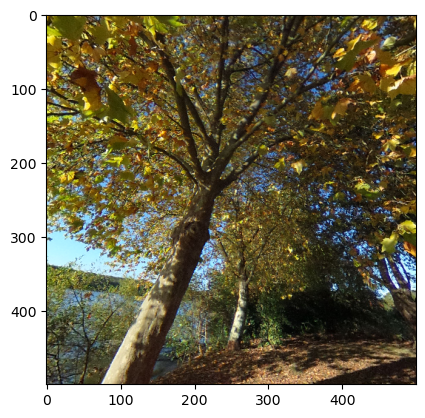

In [11]:
cp = CameraPrm(
            camera_angle=[math.radians(-90), math.radians(30)], 
            image_plane_size=(500, 500), 
            view_angle=(theta_a, phi_a)
        )
imp = imc.extract(cp)
plt.imshow(imp)

Camera angle: (-90.0, 29.999999999999996)


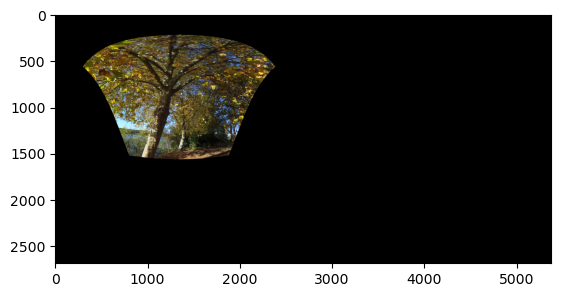

In [12]:
# embedding extracted image in omni-directional image

sz = imc.omni_image.shape
embd = Embedding(cp, (sz[1], sz[0]))
im = embd.embed(imp)
plt.imshow(im)

In [13]:
# embedding multiple extracted images in omni-directional image

# camera parameters
cp = [ CameraPrm(
        camera_angle=[math.radians(90 * t), math.radians(0)], 
        image_plane_size=(500, 500), 
        view_angle=(theta_a, phi_a)
    ) for t in range(4) ]
cp.append( CameraPrm(
        camera_angle=[math.radians(0), math.radians(90)], 
        image_plane_size=(500, 500), 
        view_angle=(theta_a, phi_a)
    ) )
cp.append( CameraPrm(
        camera_angle=[math.radians(0), math.radians(-90)], 
        image_plane_size=(500, 500), 
        view_angle=(theta_a, phi_a)
    ) )

# extracting images
imp = [ imc.extract(cp[num]) for num in range(len(cp)) ]

# embedding images in omni-directional image
sz = imc.omni_image.shape
embd = [Embedding(cp[num], (sz[1], sz[0])) for num in range(len(cp))]
im = [embd[num].embed(imp[num]) for num in range(len(cp))]
mask = [embd[num].mask for num in range(len(cp))]

print('Number of extracted images: ' + str(len(im)))

Camera angle: (0.0, 0.0)
Camera angle: (90.0, 0.0)
Camera angle: (180.0, 0.0)
Camera angle: (270.0, 0.0)
Camera angle: (0.0, 90.0)
Camera angle: (0.0, -90.0)
Number of extracted images: 6


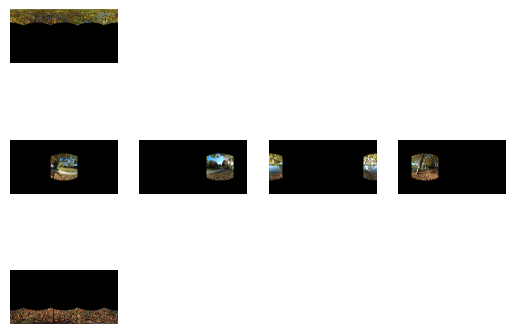

In [14]:
# display
plt.subplot(3, 4, 5)
plt.imshow(im[0])
plt.axis('off')
plt.subplot(3, 4, 6)
plt.imshow(im[1])
plt.axis('off')
plt.subplot(3, 4, 7)
plt.imshow(im[2])
plt.axis('off')
plt.subplot(3, 4, 8)
plt.imshow(im[3])
plt.axis('off')
plt.subplot(3, 4, 1)
plt.imshow(im[4])
plt.axis('off')
plt.subplot(3, 4, 9)
plt.axis('off')
plt.imshow(im[5])

Overlapping dots: 0/14450688, Missing dots: 0/14450688


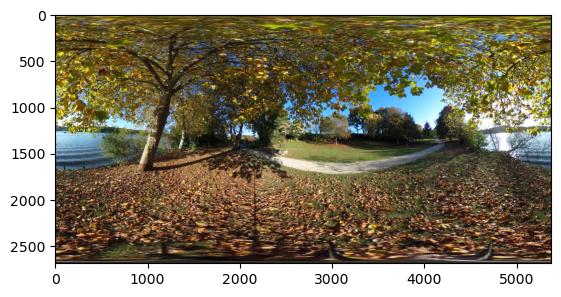

In [15]:
# integration
im = np.array(im)
mask = np.array(mask)
im_sum = np.sum(im, axis=0)
mask_all = np.sum(mask, axis=0)
print('Overlapping dots: ' + str(np.sum(mask_all > 1)) + \
      '/' + str(mask_all.shape[0]*mask_all.shape[1]) + \
      ', Missing dots: ' + str(np.sum(mask_all == 0)) + \
      '/' + str(mask_all.shape[0]*mask_all.shape[1]))
im_all = im_sum / 255.0 / mask_all.reshape(im_sum.shape[0], im_sum.shape[1], -1)
plt.imshow(im_all)